In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import copy as cp
from math import *
import datetime as dt
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
#
import scipy
import scipy.integrate as integrate
from scipy.optimize import root
from scipy.optimize import least_squares
from numpy import linalg as LA
import sympy as sym

In [3]:
# write list to binary file
def write2pickle(file, fname):
    # store list in binary file so 'wb' mode
    with open(fname, 'wb') as f:
        pickle.dump(file, f)
        print('Done writing list into a binary file')

# Read list to memory
def read_pickle(fname):
    # for reading also binary mode is important
    with open(fname, 'rb') as f:
        file = pd.read_pickle(f)
        return file

# Chech directories exit. Create if not
def check_dir_exist(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

In [4]:
# This is to enable inline displays
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Plot parameters
rcParams['figure.figsize'] = 6,4

# Seaborn settings for notebook
rc = {'lines.linewidth': 1.,
      'axes.titlesize': 14,
      'axes.labelsize': 14,
      'xtick.labelsize': 10,
      'ytick.labelsize': 10,
      'legend.fontsize': 10,
      'savefig.dpi': 300,
      'axes.facecolor': 'white'}
sns.set_context('notebook', rc=rc)
sns.set_style('ticks', rc=rc)

In [5]:
# Set colors
colormap = ['magenta',
           'darkcyan',
           'darkseagreen',
           'green',
           'royalblue',
           'orangered',
           'steelblue',
           'peru',
           'skyblue',
           'firebrick',
           'blue',
           'red']

# Set found stationary solutions

In [6]:
# Set changable model parameters
dir_sts = "stat_sols/"
# exec_file = dir_sts+"model_0_literature.py" # first reference
# exec_file = dir_sts+"model_1_demethylated.py" # after demethylation (first estimation)
exec_file = dir_sts+"model_2_intact.py" # intact (second estimation)
# exec_file = dir_sts+"model_2_intact_azaC.py" # intact+azaC (second estimation)

# Execute from file
exec(open(exec_file).read())

# Set model

In [8]:
# Wild type values
awt = 5.33e9  # characteristic number of ATP
Lwt = 1064.   # number of LINE-1 in wild type
Swt = 13243.  # number of SINE in wild type

### Constants: ###
Ng       = 3.08e9  # total genome size [bp]
Q        = 3804.   # number of housekeeping genes
nq       = 431.    # median HeLa cell protein length [aa]
nQ       = 1300.   # median HeLa housekeeping gene length [bp]
nL       = 6000.   # LINE-1 length [bp]
nS       = 300.    # SINE length [bp]
Naa      = 5.      # number of ATP molecules for adding a.a. [m.p.c. - mol. per cell]
Nnt      = 15.     # number of ATP molecules for adding nt. [m.p.c.]
tdiv     = 22.*60  # HeLa cell cycle duration, in minutes [min] ( == 1320 min )

### Parameter values: ###
rtot     = 9.5e6   # total number of ribosomes [m.p.c.]
Xi_max_L = 840.    # maximal integration elongation rate of one LINE-1 transposon [bp/(m.p.c.*min)]
Xi_max_S = 840.    # maximal integration elongation rate of one SINE transposon [bp/(m.p.c.*min)]
K_Xi_L   = 1.1e7   # integration elongation threshold of LINE-1 transposons [m.p.c.]
K_Xi_S   = 1.1e7   # integration elongation threshold of SINE transposons [m.p.c.]
KL       = 2.24e-3 # association constant of LINE-1 mRNA with ORF1p [1/m.p.c.]
wq       = 4.64    # maximal transcription rate of one gene [m.p.c./min]
wL       = 1.      # maximal transcription rate of one LINE-1 [m.p.c./min]
wS       = 20.     # maximal transcription rate of one SINE [m.p.c./min]
Th_nr_q  = 3.8e9   # transcription threshold of one gene [m.p.c.]
Th_nr_L  = 3.8e9   # transcription threshold of one LINE-1 [m.p.c.]
Th_nr_S  = 3.8e9   # transcription threshold of one SINE [m.p.c.]
gm_max_q = 300.    # maximal translation rate of q-RNA (aa/min) [a.a./(m.p.c.*min)]
gm_max_L = 300.    # maximal translation rate of LINE-1 RNA (aa/min) [a.a./(m.p.c.*min)]
K_gm_q   = 25900.  # translation threshold of one q-RNA [m.p.c.]
K_gm_L   = 25900.  # translation threshold of one LINE-1 RNA [m.p.c.]
k_bq     = 5e-8    # 2.7e-2 # cq complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_bL     = 5e-8    # 2.7e-2 # cL complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_uq     = 1e-2    # 1e3 # cq complexes unbinding rate constant
k_uL     = 1e-2    # 1e3 # cL complexes unbinding rate constant
k_subS   = 5e-8    # 6e-8 # bS formation (ORFp2+mS) substitution of mL
k_subL   = 5e-6    # 6e-8 # bL formation (ORFp2+mL) substitution of mS
d_mq     = 1.15e-3 # q-RNAs degradation rate constant [1/min]
d_cq     = 1.55e-3 # cq complexes degradation rate constant [1/min]
d_q      = 5.67e-4 # q proteins degradation rate constant [1/min]
d_mL     = 1.15e-3 # LINE-1 RNAs degradation rate constant [1/min]
d_mS     = 1.15e-3 # ! # SINE RNAs degradation rate constant [1/min]
d_cL     = 1.55e-3 # cL complexes degradation rate constant [1/min]
d_O1     = 5.67e-4 # ORF1p degradation rate constant [1/min]
d_bL     = 5.67e-4 # bL complexes degradation rate constant [1/min]
d_bS     = 5.67e-4 # bS complexes degradation rate constant [1/min]

# Add some
rib = rtot - cq0 - cL0 # number of free ribosomes
vrepl_max = Nnt*(Ng/tdiv)/0.8
k_vrepl = 0.25*a0

In [7]:
# Set dictionary with parameter names (for plotting)
par_dict_names = {
    "Ng"       : '$N_g$',
    "Q"        : '$Q$',    
    "nq"       : '$n_q$',
    "nQ"       : '$n_Q$',
    "nL"       : '$n_L$',
    "nS"       : '$n_S$',
    "Naa"      : '$N_{aa}$',
    "Nnt"      : '$N_{nt}$',
    "tdiv"      : r'$\tau$',
    #
    "rtot"     : '$r_{tot}$',
    "Xi_max_L" : r'$\chi_L$',
    "Xi_max_S" : r'$\chi_S$',
    "K_Xi_L"   : r'$K_{\chi L}$',
    "K_Xi_S"   : r'$K_{\chi S}$',
    "KL"       : '$K_L$',
    "wq"       : '$w_q$',
    "wL"       : '$w_L$',
    "wS"       : '$w_S$',
    "Th_nr_q"  : r'$\theta_q$',
    "Th_nr_L"  : r'$\theta_L$',
    "Th_nr_S"  : r'$\theta_S$',
    "gm_max_q" : r'$\gamma_q$',
    "gm_max_L" : r'$\gamma_L$',
    "K_gm_q"   : r'$K_{\gamma q}$',
    "K_gm_L"   : r'$K_{\gamma L}$',
    "k_bq"     : '$k_{bq}$',
    "k_bL"     : '$k_{bL}$',
    "k_uq"     : '$k_{uq}$',
    "k_uL"     : '$k_{uL}$',
    "k_subS"   : '$k_{subS}$',
    "k_subL"   : '$k_{subL}$',
    "d_mq"     : '$d_{mq}$',
    "d_cq"     : '$d_{cq}$',
    "d_q"      : '$d_{q}$',
    "d_mL"     : '$d_{mL}$',
    "d_mS"     : '$d_{mS}$',
    "d_cL"     : '$d_{cL}$',
    "d_O1"     : '$d_{O1}$',
    "d_bL"     : '$d_{bL}$',
    "d_bS"     : '$d_{bS}$',
    # changable
    "A0"       : '$A_0$',
    "lmd_a"    : r'$\lambda_a$',
    "lmd_L"    : r'$\lambda_L$',
    "lmd_S"    : r'$\lambda_S$'
}

In [9]:
# Set dictionary with parameters
par_dict = {
    "Ng"       : Ng,
    "Q"        : Q,    
    "nq"       : nq,
    "nQ"       : nQ,
    "nL"       : nL,
    "nS"       : nS,
    "Naa"      : Naa,
    "Nnt"      : Nnt,
    "tdiv"     : tdiv,
    #
    "rtot"     : rtot,
    "Xi_max_L" : Xi_max_L,
    "Xi_max_S" : Xi_max_S,
    "K_Xi_L"   : K_Xi_L,
    "K_Xi_S"   : K_Xi_S,
    "KL"       : KL,
    "wq"       : wq,
    "wL"       : wL,
    "wS"       : wS,
    "Th_nr_q"  : Th_nr_q,
    "Th_nr_L"  : Th_nr_L,
    "Th_nr_S"  : Th_nr_S,
    "gm_max_q" : gm_max_q,
    "gm_max_L" : gm_max_L,
    "K_gm_q"   : K_gm_q,
    "K_gm_L"   : K_gm_L ,
    "k_bq"     : k_bq,
    "k_bL"     : k_bL,
    "k_uq"     : k_uq,
    "k_uL"     : k_uL,
    "k_subS"   : k_subS,
    "k_subL"   : k_subL,
    "d_mq"     : d_mq,
    "d_cq"     : d_cq,
    "d_q"      : d_q,
    "d_mL"     : d_mL,
    "d_mS"     : d_mS,
    "d_cL"     : d_cL,
    "d_O1"     : d_O1,
    "d_bL"     : d_bL,
    "d_bS"     : d_bS,
    #
    "A0"       : A0,
    "lmd_a"    : lmd_a,
    "lmd_L"    : lmd_L,
    "lmd_S"    : lmd_S
}

# Copy dictionary
pdict = cp.deepcopy(par_dict)

In [10]:
# Set symbols
a,mq,cq,q,mL,mS,cL,O1,bL,bS,L,S = sym.symbols(r'a,mq,cq,q,mL,mS,cL,O1,bL,bS,L,S')
Ng,Q,nq,nQ,nL,nS,Naa,Nnt,tdiv = sym.symbols(r'Ng,Q,nq,nQ,nL,nS,Naa,Nnt,tdiv')
rtot,Xi_max_L,Xi_max_S,K_Xi_L,K_Xi_S,KL = sym.symbols(r'rtot,Xi_max_L,Xi_max_S,K_Xi_L,K_Xi_S,KL')
wq,wL,wS,Th_nr_q,Th_nr_L,Th_nr_S = sym.symbols(r'wq,wL,wS,Th_nr_q,Th_nr_L,Th_nr_S')
gm_max_q,gm_max_L,K_gm_q,K_gm_L = sym.symbols(r'gm_max_q,gm_max_L,K_gm_q,K_gm_L')
k_bq,k_bL,k_uq,k_uL,k_subS,k_subL = sym.symbols(r'k_bq,k_bL,k_uq,k_uL,k_subS,k_subL,')
d_mq,d_cq,d_q,d_mL,d_mS,d_cL,d_O1,d_bL,d_bS = sym.symbols(r'd_mq,d_cq,d_q,d_mL,d_mS,d_cL,d_O1,d_bL,d_bS')
A0,lmd_a,lmd_L,lmd_S = sym.symbols(r'A0,lmd_a,lmd_L,lmd_S')
# variables
var = a,mq,cq,q,mL,mS,cL,O1,bL,bS,L,S

In [11]:
# translation rates:
def vq(cq_, a_):
    return gm_max_q/nq*cq_*a_/(K_gm_q+a_)

def vL(cL_,a_):
    return gm_max_L/(nL/3)*cL_*a_/(K_gm_L+a_)

# integration rates:
def vintL(bL_,O1_,a_):
    return Xi_max_L/nL * bL_*a_/(K_Xi_L+a_)*KL*O1_/(1+KL*O1_)

def vintS(bS_,a_):
    return Xi_max_S/nS * bS_*a_/(K_Xi_S+a_)

# transcription rates:
def om_q(a_):
    return Q*wq*a_/(Th_nr_q+a_)

def om_L(L_,a_):
    return L_*wL*a_/(Th_nr_L+a_)

def om_S(S_,a_):
    return S_*wS*a_/(Th_nr_S+a_)

# replication:
# def vreplf(a_):
#     return vrepl_max*a_/(a_+k_vrepl)

# replication:
def vreplf(a_,bL_,O1_,bS_):
    return Nnt*(Ng/tdiv + vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS)

# ribosomes:
def ribf(cq_,cL_):
    return rtot-cq_-cL_

# Check stability

In [12]:
# Function for minimization
def solve_sym(y):
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    eqs = [ A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
           - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
           - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
           - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
            om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_ - d_mq*mq_, # dmq/dt
            k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
            vq(cq_,a_) - d_q*q_, # dq/dt
            om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
            om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
            k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
            vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
            vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
            k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
            vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
            vintS(bS_,a_) - lmd_S*S_ # dS/dt
           ]
    eqs = sym.Matrix(eqs)
    eqs = eqs.subs(par_dict)
    return eqs

## Check stability for reference

In [13]:
# Stationary solution
incond = sty0.copy() # referennce

# Get dict. with stable solution
res_dict = {}
for i,v in enumerate(var):
    # print(i,v)
    res_dict[v] = incond[i]

# check stability
M = solve_sym(var).jacobian(var)
Msub = M.subs(res_dict)
Msub_np = np.array(Msub).astype(np.float64)
eig_w, eig_v = LA.eig(Msub_np)
print('Stable:', (eig_w<0).all())
print(f'Eigenvalues({len(eig_w)}):\n', eig_w)

Stable: True
Eigenvalues(12):
 [-5.67000000e-04+0.j         -1.11320219e+01+0.j
 -1.48755763e+00+0.j         -2.59769771e+00+0.j
 -2.46033474e+00+0.j         -4.52257320e-01+0.j
 -5.18987169e-01+0.j         -1.22287249e-03+0.j
 -4.28426486e-04+0.00103067j -4.28426486e-04-0.00103067j
 -2.87098786e-04+0.j         -5.66996790e-04+0.j        ]


## Check stability knock-S

In [14]:
# Stationary solution
incond = sty1.copy() # knock-S

# Get dict. with stable solution
res_dict = {}
for i,v in enumerate(var):
    # print(i,v)
    res_dict[v] = incond[i]

# check stability in base system
M = solve_sym(var).jacobian(var)
Msub = M.subs(res_dict)
Msub_np = np.array(Msub).astype(np.float64)
eig_w, eig_v = LA.eig(Msub_np)
print('Stable:', (eig_w<0).all())
print(f'Eigenvalues({len(eig_w)}):\n', eig_w)

Stable: False
Eigenvalues(12):
 [-5.67000000e-04+0.j         -1.30311056e+00+0.j
 -6.30823480e-01+0.j         -4.03342761e-01+0.23616555j
 -4.03342761e-01-0.23616555j -1.24671059e-03+0.j
 -3.71756949e-02+0.15939576j -3.71756949e-02-0.15939576j
 -3.14551273e+00+0.j         -2.67986710e+00+0.j
 -5.67000000e-04+0.j          3.13209734e-02+0.j        ]


In [15]:
# Function for minimization
def solve_sym_knock_S(y):
    a_,mq_,cq_,q_,mL_,cL_,O1_,bL_,L_ = y
    eqs = [ A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,0.) # energy supply + ATP degradation + replication
           - Nnt * ( om_q(a_)*(nQ) + om_L(L_,a_)*nL ) # transcription
           - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
           - Nnt * ( vintL(bL_,O1_,a_)*nL ), # integration # da/dt
            om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_ - d_mq*mq_, # dmq/dt
            k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
            vq(cq_,a_) - d_q*q_, # dq/dt
            om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ - d_mL*mL_, # dmL/dt
            k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
            vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
            vL(cL_,a_) - vintL(bL_,O1_,a_) - d_bL*bL_, # dbL/dt
            vintL(bL_,O1_,a_) - lmd_L*L_ # dL/dt
           ]
    eqs = sym.Matrix(eqs)
    eqs = eqs.subs(par_dict)
    return eqs

In [16]:
# check stability in reduced system
var_S = a,mq,cq,q,mL,cL,O1,bL,L
M = solve_sym_knock_S(var_S).jacobian(var_S)
Msub = M.subs(res_dict)
Msub_np = np.array(Msub).astype(np.float64)
eig_w, eig_v = LA.eig(Msub_np)
print('Stable:', (eig_w<0).all())
print(f'Eigenvalues({len(eig_w)}):\n', eig_w)

Stable: True
Eigenvalues(9):
 [-5.67000000e-04+0.j         -1.30311056e+00+0.j
 -6.30823480e-01+0.j         -4.03342761e-01+0.23616555j
 -4.03342761e-01-0.23616555j -3.71756949e-02+0.15939576j
 -3.71756949e-02-0.15939576j -1.24671059e-03+0.j
 -5.67000000e-04+0.j        ]


## Check stability knock-LS

In [17]:
# Stable solution
incond = sty2.copy() # knock-LS

# Get dict. with stable solution
res_dict = {}
for i,v in enumerate(var):
    # print(i,v)
    res_dict[v] = incond[i]

# check stability in base system
M = solve_sym(var).jacobian(var)
Msub = M.subs(res_dict)
Msub_np = np.array(Msub).astype(np.float64)
eig_w, eig_v = LA.eig(Msub_np)
print('Stable:', (eig_w<0).all())
print(f'Eigenvalues({len(eig_w)}):\n', eig_w)

Stable: True
Eigenvalues(12):
 [-5.67000000e-04 -5.67000000e-04 -5.67000000e-04 -2.87037940e-04
 -1.22477952e-03 -1.48716252e+00 -1.41368709e-01 -2.99271933e-01
 -1.15000000e-03 -2.47000000e+00 -2.80056570e+00 -5.30000000e-01]


In [18]:
# Function for minimization
def solve_sym_knock_LS(y):
    a_,mq_,cq_,q_ = y
    eqs = [ A0 - lmd_a*a_ - vreplf(a_,0,0,0) # energy supply + ATP degradation + replication
           - Nnt * om_q(a_)*nQ  # transcription
           - Naa * vq(cq_,a_)*nq,  # translation # da/dt
            om_q(a_) - k_bq*ribf(cq_,0)*mq_ + vq(cq_,a_) + k_uq*cq_ - d_mq*mq_, # dmq/dt
            k_bq*ribf(cq_,0)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
            vq(cq_,a_) - d_q*q_, # dq/dt
           ]
    eqs = sym.Matrix(eqs)
    eqs = eqs.subs(par_dict)
    return eqs

In [19]:
# check stability in reduced system
var_LS = a,mq,cq,q
M = solve_sym_knock_LS(var_LS).jacobian(var_LS)
Msub = M.subs(res_dict)
Msub_np = np.array(Msub).astype(np.float64)
eig_w, eig_v = LA.eig(Msub_np)
print('Stable:', (eig_w<0).all())
print(f'Eigenvalues({len(eig_w)}):\n', eig_w)

Stable: True
Eigenvalues(4):
 [-5.67000000e-04 -1.48716252e+00 -1.22477952e-03 -2.87037940e-04]


# Find roots

In [20]:
# Function for minimization
def solve_syst(y):
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    eqs = [ A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
           - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
           - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
           - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
            om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_ - d_mq*mq_, # dmq/dt
            k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
            vq(cq_,a_) - d_q*q_, # dq/dt
            om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
            om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
            k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
            vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
            vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
            k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
            vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
            vintS(bS_,a_) - lmd_S*S_ # dS/dt
           ]
    eqs = sym.Matrix(eqs)
    eqs = np.reshape(np.array(eqs.subs(pdict)).astype(np.float64), -1)
    return eqs

In [21]:
# Find roots (reference)
incond = sty0.copy()
root0 = root(solve_syst, incond, method='lm', options={'maxiter':150})
print("success:", root0.success)
print("niter =", root0.nfev)
print(root0.x)

success: True
niter = 14
[1.70903634e+13 1.01281678e+07 3.87047959e+06 4.75144500e+09
 1.32203563e+05 2.01277667e+08 2.21289804e+05 5.75527581e+07
 4.00758209e+03 1.16512701e+04 1.05859770e+03 1.32079090e+04]


# Integrate

In [22]:
# Function for minimization
def integr_syst(t, y):
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    eqs = [ A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
           - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
           - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
           - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
            om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_ - d_mq*mq_, # dmq/dt
            k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
            vq(cq_,a_) - d_q*q_, # dq/dt
            om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
            om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
            k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
            vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
            vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
            k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
            vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
            vintS(bS_,a_) - lmd_S*S_ # dS/dt
           ]
    eqs = sym.Matrix(eqs)
    eqs = np.reshape(np.array(eqs.subs(pdict)).astype(np.float64), -1)
    return eqs

In [23]:
# Reference solution
t_start = 0.
t_finish = 500.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = 500 #int((t_finish-t_start)/step)

# set initial conditions (random)
incond = root0.x.copy()
# seed = 12345
# rng = np.random.default_rng(seed)
# rfloat = rng.random(12)
# incond += incond*(rfloat*2-1)*0.8
# incond[-2] *=1000

# integrate
sol = integrate.solve_ivp(integr_syst, t_span, incond, t_eval=t, dense_output=True, method = 'Radau')

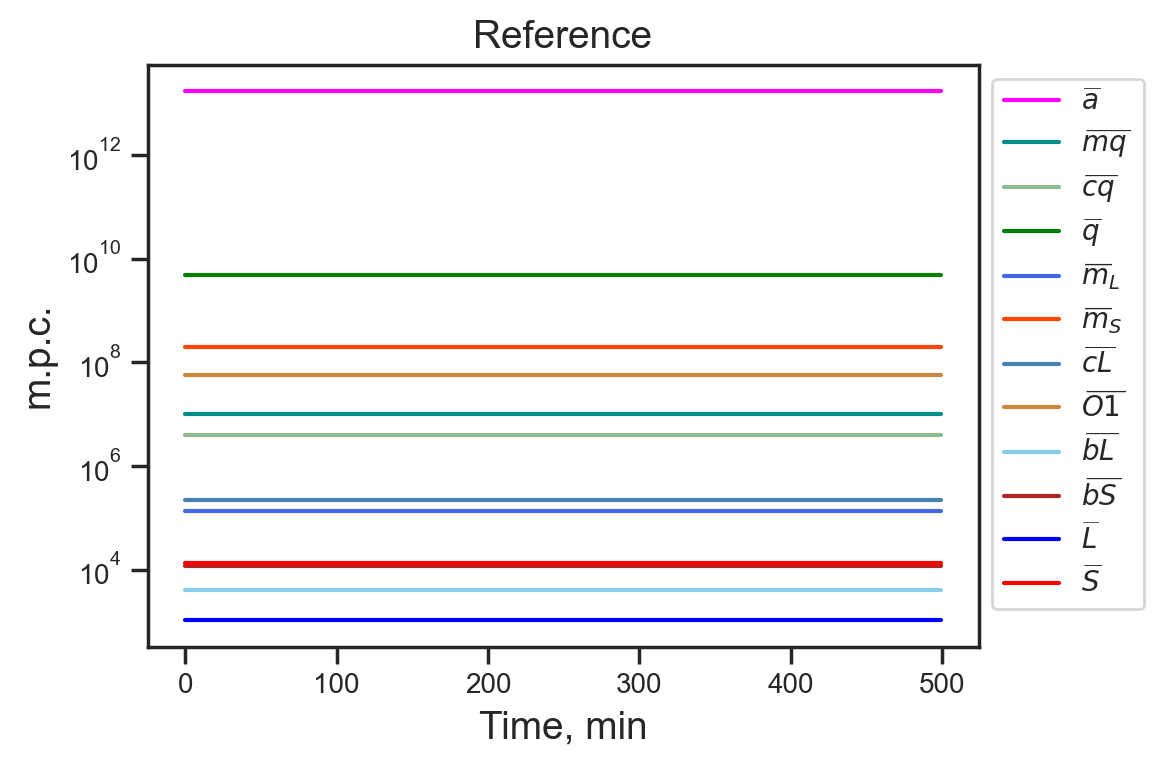

In [24]:
# Plot solution
fig, ax = plt.subplots()

ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")

# Label axes
ax.set_title('Reference')
ax.set_xlabel('Time, min')
ax.set_ylabel('m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()
plt.show()